# [IAPR][iapr]: Final project - Chocolate Recognition


**Moodle group ID:** *47*  
**Kaggle challenge:** *Deep learning*
**Kaggle team name (exact):** "*Group47-ChocoKiffeur*"  

**Author 1 (SCIPER):** *Lucas Maneff 1 (324 942)*  
**Author 2 (SCIPER):** *Jérémy Hugentobler (341 467)*  
  

**Due date:** 21.05.2025 (11:59 pm)


## Key Submission Guidelines:
- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`
- **Only groups of three will be accepted**, except in exceptional circumstances.


[iapr]: https://github.com/LTS5/iapr2025

---

In [1]:
import torch

# Data 

In this first part, we will describe our journey with the dataset needed to train our deep learning model.


## The initial dataset

The provided dataset contains images of 13 different kinds of chocolates, placed on various backgrounds where some adversarial objects are also present (round shapes, gloves, ...)

From the presentation slide, we know that *"All photos were taken under the same conditions — using the same camera, at the same distance, and with the same resolution."*, Which means that all the chocolate will be **similar in size** in each picture and that the amount of "challenges" that we have to prepare for is limited.

Initially, the training dataset contains 90 images, which is not a lot considering that we need to train a DL model from scratch. Additionaly, we took the liberty of adding the 13 reference images in the train dataset, thus obtaining a total of 103 images to train from.

We tried to train our model (described later) only on those given examples, including a random flip transformation and this gave us the following metrics:

<img src="report_data/no_synth_graph.png" width="50%"/>

The metrics will be explained in the design choice section, but we can directly see that the training loss (SmoothL1) is going back and forth during more than half of the training, which lead us to think that the model was too big for this little data and meant that we were **under-fitting**.


## Data-augmentation

Knowing that the provided data is limited, we had to think about different methods that would allow our model to train from additional data samples and we used two techniques that we combined together: **Synthetic data creation** and **image transformations**.

### Synthetic data

The goal is to create new synthetic images based on content extracted from the existing ones. The first step was to isolate each chocolate from a background, which gave the following results:

<img src="data/alpha_references/jelly_black.png" alt="Jelly Black" width="200"/>
<img src="data/alpha_references/arabia.png" alt="Arabia" width="200"/>
<img src="data/alpha_references/tentation_noir.png" alt="Tentation noir" width="200"/>


This was done manually on gimp and is quite a long task, but once we had those 13 isolated samples, we wrote a script that applies a random rotation, and optionally a random blur to each chocolate and place them on a background. The number of chocolate varies between 1 and 3 and is picked at random. 

Here is an example on an empty background that we got by manually erasing a chocolate:

Associated label: {'Jelly White': 1, 'Jelly Milk': 0, 'Jelly Black': 0, 'Amandina': 0, 'Crème brulée': 1, 'Triangolo': 0, 'Tentation noir': 0, 'Comtesse': 0, 'Noblesse': 0, 'Noir authentique': 0, 'Passion au lait': 0, 'Arabia': 1, 'Stracciatella': 0}


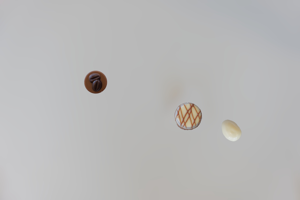

In [4]:
from src.data.synthetic_data_generation import generate_synthetic_image
from PIL import Image
background = Image.open("data/backgrounds/blank_bg1.JPG")
img, label = generate_synthetic_image(background, "data/alpha_references/", noise=True)
print("Associated label:", label)
img.resize((300, 200)) # resize for rapport visualization

We used the same mechanism, but with already existing training image as backgrounds and combined the previous label with the new synthetic one:

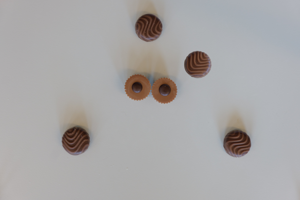

In [2]:
# On an image without a blank background
from src.data.synthetic_data_generation import generate_synthetic_image
from PIL import Image
background = Image.open("data/train/L1000792.JPG")
img, label = generate_synthetic_image(background, "data/alpha_references/", noise=True)
img.resize((300, 200)) # resize for rapport visualization

We first used a static approach, where we would generate each synthetic images ahead of time, but this process is quite cumbersome (ie. moving all your images to Google Colab at every modification), so we instead incorporated it directly into a torch Dataset that uses the training split of the data to generate the synthetic images when instantiating it. The function that is called is *generate_synthetic_dataset* (also from [synthetic_data_generation.py](src/data/synthetic_data_generation.py)), but instead of generating a single image, it iterates on all the wanted backgrounds and creates all the synthetic images.

The specific implementation of our synthetic dataset can be found in the [SyntheticChocolateDataset.py](src/data/SyntheticChocolateDataset.py) file (*datasets are in src/data*), but in short, it loads all the image of training set (excluding the validation set), gets their labels and creates the artificial data with appropriate new labels.

This dataset only containing synthetic images is then merged with the normal training dataset from [TrainChocolateDataset.py](src/data/TrainChocolateDataset.py) that contains the inital data.

> ⚠️ We separate the full training set (the 103 images) in two part for validation purposes, so the merging happens only with the training part (82 images) and our validation set (21 images) remains pure of such synthetic images.

If we generate 10 new images per original background, we get the following datasets sizes:
`
Training dataset size: 82, Validation dataset size: 21, Synthetic dataset size: 820, Merged training dataset size: 902
`

### Dataset transformation

Torch allows us to define sequences of operations to apply on our images when they are fetched from their respective Datasets and we defined two different transformations, one for the training (including synthetic images), one for the validation and test sets.

Our training tranformations combination (which is shown beneath) is composed in the following way:
We first convert each raw input into a PIL image and immediately downsample it from 6000×4000 to 120×180 pixels to reduce memory and speed up training. To increase variety, we apply random horizontal and vertical flips (each with 50% probability). Next, we cast the pixel values to float32 and rescale them to [0, 1]. Finally, we normalize each channel to help stabilize and accelerate convergence. (those values where recoreded from the train set)

We did not add additional transformation due to the information that were given in the presentation slides: the camera doesn't move, so we don't necessarily need to make our model scale invariant or ready to adapt to some unwanted camera effects.

In [ ]:
from torchvision.transforms import v2

IMG_SIZE = (120, 180)
means = [0.6887134909629822, 0.666830837726593, 0.6608285307884216]
stds =  [0.15740245580673218, 0.1555258184671402, 0.17858198285102844]

train_tf = v2.Compose([
    v2.ToImage(),
    v2.Resize(IMG_SIZE, antialias=True),     
    v2.RandomHorizontalFlip(p=0.5),           
    v2.RandomVerticalFlip(p=0.5),           
    v2.ToDtype(torch.float32, scale=True), 
    v2.Normalize(mean=means, std=stds),
])

The transformation used for the validation and the test set contains the same operation **BUT** we remove the ones that modifies the appearance of the image. (We don't apply any flips or color jittering on a test image, nor a validation set image)

In [ ]:
val_tf = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), 
    v2.Resize(IMG_SIZE, antialias=True),                
    v2.Normalize(mean=means, std=stds),
])

For more details about the implementation of those datasets and tranforms:
- *src/data/*: contains the different datasets implementation files
- [The training notebook](training.ipynb): calls the datasets, creates the transforms and contains the code to run our training procedure
- [main.py](main.py): used for inference on the test dataset, contains the test dataset instantiation and the test transformation

# Design choices

**Global architecture:**

The project goal was to automatically count the number of chocolates of each type present in an image. The first idea we had was to use a "two staged model" which would first segment each chocolate in the image and then run a classifier on each of them. However, training a segmentation model like YOLO requires having bounding boxes as labels which were not available in our case. We only had a vector $y \in R^{N}, N = 13$ that contains the class counts without positional information. That is why we decided to go for a "one stage" model composed of a feature extractor and a regression counting head without using segmentation.

**Feature extractor:**

The architecture of the backbone is based on [ResNet](https://arxiv.org/abs/1512.03385), which implements residual connections that shortcut some of the convolutional layers. The key idea is to learn the difference between the transformed image and the original image instead of building the whole transformation, which facilitates the training especially for deep networks. In this project we chose the *ResNet-18* flavour of the model, as it is the largest that fits into the size requirements. Each ResBlock (see picture below) is composed of two convolutional layers which will learn the filters that extract meaningful features of the image. The ReLU activation function is used to introduce non-linearities in the process and the batch normalization allows to stabilize the learning. At each ResBlock the number of channels is multiplied by two while the spatial dimensions are divided by two. This allows the network to learn more and more features that become increasingly abstract at deeper levels.

**Counting Head:**

The counting head takes the features as input and outputs a prediction count. Each feature map is averaged into a single value which is then fed into a 2-layer perceptron with hidden size of 512 and output size of 13 (one for each class). We add dropout during training between the two linear layers to reduce overfitting.

<img src="report_data/Full diagram.png">

### Technical description

**Neural network:**

The architecture is detailed above.

**Loss function:**

The function that we want to maximize is the F1 score as defined below:

Let $y \in \mathbb{N}_0^{N \times C}$ and $\hat{y} \in \mathbb{N}_0^{N \times C}$ be the ground truth and the prediction respectively,

$$
F1 = \frac{1}{N} \sum_{i=1}^{N} \frac{2 \, \mathrm{TP}_i}{2 \, \mathrm{TP}_i + \mathrm{FPN}_i}
$$

where

$$
\mathrm{TP}_i = \sum_{j=1}^{C} \min(y_{i,j}, \hat{y}_{i,j}), \quad 
\mathrm{FPN}_i = \sum_{j=1}^{C} |y_{i,j} - \hat{y}_{i,j}|
$$

Because of the min() function, This F1-score can not be differentiated and thus can not be used for optimization. Instead we chose to minimize a surrogate loss: the smoothed l1 loss (with $\beta = 1$), which is defined as follows:

$$L = \frac{1}{N} \sum_{i=1}^N l_i$$

with

$$
l_i = \begin{cases}
\frac{1}{\beta}(x_i, y_i)^2 \quad \text{if} \quad |x_i - y_i| < \beta \\
|x_i - y_i| - \frac{\beta}{2} \quad \text{otherwise}
\end{cases}
$$

This loss is more robust to outliers than the Mean Squared Error, which makes it suitable for counting tasks where the model could occasionally be completely off for example, in images with a large number of chocolates. It prevents the gradients from being dominated by these large errors thanks to the L1-like behavior for big differences, while still providing precise adjustments when predictions are close to the ground truth due to its L2-like behavior near zero error.

> Note:  Even though the output has to be rounded to obtain the final count predictions, the loss is computed on the float predictions.

**Optimizer:**

The optimizer is a classic Adam optimizer with an initial learning rate of 1e-3.



# Results

Sadly, we were not able to beat the TA's baseline on Kaggle despite many efforts and different techniques. Our best result was: 0.63451 and we could not improve on that.

This best score was obtained using the approach described above, where the synthetic data generator added 10 new images per training image and the Huber loss was used. We kept track of the training loss, the validation loss and implemented Kaggle's score computation on the validation set (referred as F1 here) to have an idea of the performance on the final leaderboard and you can find this run in the upper part of the following graph. (F1 is supposed to be big and grows in the opposite direction as the losses)

<img src="report_data/golder_run_graph.png" width="50%"/>

When looking at the run, we saw that the our metrices were going back and fourth past a certain point and not making any important progress, which could have meant that the learning rate was not appropriate at this stage of the training.

This is why we added a **ReduceLROnPlateau** scheduler that would multiply the learning rate by 0.8 each time the model got stuck (5 epochs without beating it's last best F1 score) and the results are shown in the second graph. This gave us smoother curves, but we didn't get results as good as our best run, which could be due to the fact that we tried to add a small color jittering effect (which might not have generalized well) or to the randomness of the stochastic gradient descent.

From those graphs, our model and training routine seems to make the model learn quite effectively on the train set (the train loss converged to good scores rapidely), but our validation metrics were not converging as fast as the training one. We can also see that the "gap" between the training loss and validation loss doesn't close at a significant rate, but we don't think that the model is  overfitting since the validation metrics were not getting worse but stayed at a consistent level. Adding more synthetic data made the training loss dive faster, but the same validation metrics issue remained. 

## Chocolate activation
WORK WITH THE GRAPHS

# What could have been done better

**GPUs**: A big limitation to our experimentations was the time it took to train the model with each feature and the lack of dedicated GPUs to the project. We used Google Colab for most of the trainings, but this platform was quite unstable and made us lose some runs, and therefore time. Maybe an access to gnoto or one of the school's GPU cluster could have helped us.

**Manual synthetic images**: Instead of the fully automated synthetic images generation process that we made, it could have been better to make a visual tool that let's you define where new chocolates can be placed since our current algorithm is agnostic of the placement of the background's chocolate, which could lead to some sever occlusions. To limit this phenomenom, we also tried to put only one new random chocolate on backgrounds (instead of a random amount from 1 to 4)

**Model Choice**: If we had had enough time, it would have been beneficial to experiment with different model, and compare their performance. We thought of trying a YOLO implementation, but this would have required manual bounding box labeling on each of the training images and would have made the image transformations a bit trickier to implement.





